# Missing on real World
This notebooks tests the relevance of nodes for the two real world datasets Powergrid and Internet. We randomly remove a certain percent of nodes.

Then we predict the infection center again (without simulation at first) and measure the removals impact.

In [1]:
import networkx as nx
import rumor_centrality.rumor_detection as raw
import rumor_centrality.jordan_center_alternative as jo
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from rumor_centrality.graph_generator import internet, us_power_grid, scale_free, synthetic_internet
from time import time
from multiprocessing import Pool
from typing import List, Tuple, Dict
from rumor_centrality.graph_simulations import si
from rumor_centrality.graph_visualization import plot_nx_graph
import random
import pickle
from os.path import join

In [31]:
metrics = {
    "rumor_centrality" : lambda g: raw.get_center_prediction(
        raw.networkx_graph_to_adj_list(g), use_fact=False
    ),
    "jordan_centrality": jo.centers_by_jordan_center,
    "betweenness_centrality": jo.centers_by_betweenness_centrality,
    "distance_centrality": jo.centers_by_distance_centrality,
}

In [76]:
g = nx.Graph(scale_free(10))
rumor_center_lookup = raw.get_rumor_centrality_lookup(raw.networkx_graph_to_adj_list(g))
markers = list(map(lambda x: x[1], sorted(rumor_center_lookup.items())))
plot_nx_graph(g, markers, [f"node {n} - {markers[i]}" for i, n in enumerate(g.nodes)])

In [77]:
def remove_node_and_reconnect(g, node):
    neighbors = list(g.neighbors(node))
    for i in neighbors:
        for j in neighbors:
            if i != j:
                # Duplicated edges naturally not possible on a graph
                g.add_edge(i, j)
    # g.remove_node(node)
    
remove_node_and_reconnect(g, 0)
rumor_center_lookup = raw.get_rumor_centrality_lookup(raw.networkx_graph_to_adj_list(g))
markers = list(map(lambda x: x[1], sorted(rumor_center_lookup.items())))
plot_nx_graph(g, markers, [f"node {n} - {markers[i]}" for i, n in enumerate(g.nodes)])

In [78]:
g.remove_node(0)

In [79]:
rumor_center_lookup = raw.get_rumor_centrality_lookup(raw.networkx_graph_to_adj_list(g))
markers = list(map(lambda x: x[1], sorted(rumor_center_lookup.items())))
plot_nx_graph(g, markers, [f"node {n} - {markers[i]}" for i, n in enumerate(g.nodes)])

In [2]:
metrics = {
    "rumor_centrality" : lambda g: raw.get_center_prediction(
        raw.networkx_graph_to_adj_list(g), use_fact=False
    ),
    "jordan_centrality": jo.centers_by_jordan_center,
    "betweenness_centrality": jo.centers_by_betweenness_centrality,
    "distance_centrality": jo.centers_by_distance_centrality,
}

In [3]:
graph_callback = lambda: synthetic_internet(100)
graph_name = "synthetic_internet"
sample_size = 10
percent_radius = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  # Percent of nodes to remove

output_dir = None

In [4]:
graph_size = len(graph_callback().nodes)

In [5]:
def name_builder(name, pickle=True):
    postfix = ""
    if pickle:
        postfix = ".pickle"
    return f"{name}__config_graph_{graph_name}_nodes_{graph_size}_samples_{sample_size}_metric_{metric_name}{postfix}"

In [6]:
main_ref_graph = graph_callback().copy(as_view=True)

In [7]:
if output_dir is not None:
    with open(join(output_dir, name_builder("main_ref_graph")), "wb") as f:
        pickle.dump(main_ref_graph, f)

In [8]:
def get_hop_distance(g, center, predicted_center):
    return nx.shortest_path_length(g, center, predicted_center)

In [9]:
def remove_node_and_reconnect(g, node):
    neighbors = list(g.neighbors(node))
    for i in neighbors:
        for j in neighbors:
            if i != j:
                # Duplicated edges naturally not possible on a graph
                g.add_edge(i, j)
    g.remove_node(node)

In [10]:
import_graph = None
def get_experiment_graph(g, percent_missing):
    g = g.copy(as_view=True)
    nodes_to_remove = int(len(g.nodes) * percent_missing)

    _g = g.copy()
    removed_nodes = []
    for _ in range(nodes_to_remove):
        node_to_remove = random.choice(list(_g.nodes))
        remove_node_and_reconnect(_g, node_to_remove)
        removed_nodes.append(node_to_remove)
    return _g, removed_nodes

In [11]:
results = {}

with tqdm(total=len(percent_radius) * sample_size) as bar:
    for p_r in percent_radius:
        results[p_r] = []
        for _ in range(sample_size):
            ex_graph, removed_nodes = get_experiment_graph(main_ref_graph, p_r)
            predicted_centers = {}
            for metric_name, metric_callback in metrics.items():
                predicted_centers[metric_name] = metric_callback(ex_graph)
            
            r = {
                "predicted_centers": predicted_centers,
                "ex_graph": ex_graph,
                "removed_nodes": removed_nodes,
            }
            
            results[p_r].append(r)
            bar.update(1)

100%|█████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 31.34it/s]


In [12]:
if output_dir is not None:
    with open(join(output_dir, name_builder("results")), "wb") as f:
        pickle.dump(results, f)

In [13]:
shortest_paths = nx.shortest_path(main_ref_graph)

In [14]:
def get_best_hop_distance(g, original_centers, predicted_centers):
    best_pair = None
    best_distance = len(g.nodes)
    for o_c in original_centers:
        for p_c in predicted_centers:
            d = len(shortest_paths[o_c][p_c])
            if d < best_distance:
                best_distance = d
                best_pair = (o_c, p_c)
    return best_pair, best_distance

In [15]:
def get_all_hop_distances(g, original_centers, predicted_centers):
    distances = []
    for o_c in original_centers:
        for p_c in predicted_centers:
            distances.append(len(shortest_paths[o_c][p_c]))
    return distances

In [16]:
unaltered_center_prediction = metric_callback(main_ref_graph)

In [17]:
center_results = {}
for k, v in results.items():
    predicted_centers = []
    for _r in v:
        predicted_centers.append(_r["predicted_centers"])
    center_results[k] = predicted_centers

In [18]:
reference_map = []

# Map results to hop distances
hop_distance_freq_by_p_r_by_metric = {}

for metric_name in metrics.keys():
    hop_distance_freq_by_p_r = {}
    for p_r, values in tqdm(center_results.items()):
        hop_distance_freq = {}
        for i, centers in tqdm(enumerate(values)):
            centers = centers[metric_name]
            best_pair, best_distance = get_best_hop_distance(main_ref_graph, unaltered_center_prediction, centers)
            hop_distance_freq[best_distance] = hop_distance_freq.get(best_distance, 0) + 1

            reference_map.append((p_r, i, best_distance))

        hop_distance_freq_by_p_r[p_r] = hop_distance_freq
    hop_distance_freq_by_p_r_by_metric[metric_name] = hop_distance_freq_by_p_r

  0%|                                                                   | 0/9 [00:00<?, ?it/s]
10it [00:00, 64231.30it/s]

10it [00:00, 84222.97it/s]

10it [00:00, 146143.00it/s]

10it [00:00, 82891.38it/s]

10it [00:00, 108379.95it/s]

10it [00:00, 103563.06it/s]

10it [00:00, 89621.88it/s]

10it [00:00, 97769.32it/s]

10it [00:00, 68089.35it/s]
  0%|                                                                   | 0/9 [00:00<?, ?it/s]
10it [00:00, 66052.03it/s]

10it [00:00, 56987.83it/s]

10it [00:00, 55188.21it/s]

10it [00:00, 35010.88it/s]

10it [00:00, 34606.47it/s]

10it [00:00, 56299.38it/s]

10it [00:00, 39983.83it/s]

10it [00:00, 53635.60it/s]

10it [00:00, 45100.04it/s]
  0%|                                                                   | 0/9 [00:00<?, ?it/s]
10it [00:00, 52167.96it/s]

10it [00:00, 58743.75it/s]

10it [00:00, 73843.38it/s]

10it [00:00, 10968.37it/s]

10it [00:00, 57852.47it/s]

10it [00:00, 56987.83it/s]

10it [00:00, 73199.02it/s]

10it [00:00, 5

In [19]:
if output_dir is not None:
    with open(join(output_dir, name_builder("hop_distance_freq_by_p_r")), "wb") as f:
        pickle.dump(hop_distance_freq_by_p_r, f)
    with open(join(output_dir, name_builder("reference_map")), "wb") as f:
        pickle.dump(reference_map, f)

In [20]:
def rgba(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 200*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return r, g, b, 200

min_v = min(percent_radius)
max_v = max(percent_radius)

In [21]:
from pandas import DataFrame

def plot_metric(metric_name, ax):
    hop_distance_freq_by_p_r = hop_distance_freq_by_p_r_by_metric[metric_name]
    colors = ['#%02x%02x%02x%02x' % rgba(min_v, max_v, p) for p in hop_distance_freq_by_p_r.keys()]

    df = DataFrame(hop_distance_freq_by_p_r)
    df = df.reindex(index=sorted(df.index))
    df.plot.bar(color=colors, ax=ax, width=1)
    ax.set_title(f"{metric_name}")
    ax.set_ylabel("Freq")
    ax.set_xlabel("Hop Distance")
    return ax

In [22]:
from pandas import DataFrame

def plot_metric_stacked(metric_name, ax):

    hop_distance_freq_by_p_r = hop_distance_freq_by_p_r_by_metric[metric_name]

    df = DataFrame(hop_distance_freq_by_p_r)
    df = df.reindex(index=sorted(df.index))
    df = df.transpose()

    colors = ['#%02x%02x%02x%02x' % rgba(0, 20, hop) for hop in list(df.columns)]

    df.plot.bar(color=colors, stacked=True, ax=ax)
    ax.set_title(f"{metric_name}")
    ax.set_ylabel("Freq")
    ax.set_xlabel("Hop Distance")
    return ax

/tmp/ipykernel_6660/3646724902.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


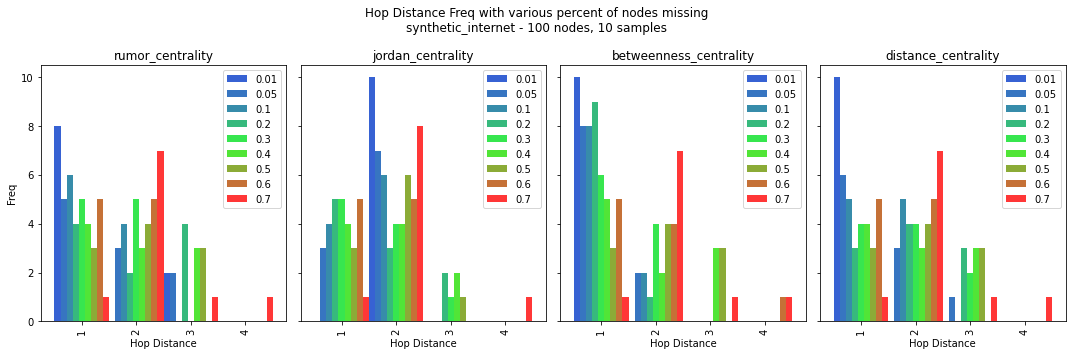

In [23]:
fig, axes = plt.subplots(1, len(metrics), figsize=(15,5), sharey=True)

for i, metric in enumerate(metrics):
    plot_metric(metric, axes[i])
fig.suptitle(f"Hop Distance Freq with various percent of nodes missing\n{graph_name} - {graph_size} nodes, {sample_size} samples")
fig.tight_layout()
fig.show()

/tmp/ipykernel_6660/1715910281.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


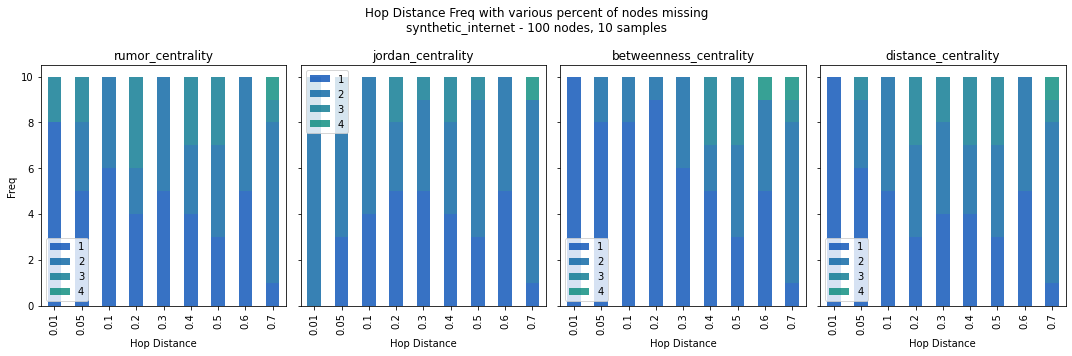

In [24]:
fig, axes = plt.subplots(1, len(metrics), figsize=(15,5), sharey=True)

for i, metric in enumerate(metrics):
    plot_metric_stacked(metric, axes[i])
fig.suptitle(f"Hop Distance Freq with various percent of nodes missing\n{graph_name} - {graph_size} nodes, {sample_size} samples")
fig.tight_layout()
fig.show()

## Results
### Scale Free
![](progress_pictures/missing_tests/scale_free_100.png)
![](progress_pictures/missing_tests/scale_free_100_stacked_edit.png)

![](progress_pictures/missing_tests/scale_free_1000.png)
![](progress_pictures/missing_tests/scale_free_1000_stacked_edit.png)

- Larger size decreases accuracy
- All metrics pretty similar, jordan center <s>wins at larger scale</s> looses at larger scale

### Synthetic Internet
![](progress_pictures/missing_tests/syn_int_100.png)
![](progress_pictures/missing_tests/syn_int_100_stacked_edit.png)
![](progress_pictures/missing_tests/syn_int_1000.png)
![](progress_pictures/missing_tests/syn_int_1000_stacked_edit.png)

- Larger size decreases accuracy
- Jordan Centers seem more resilient than the other measures
- Other metrics pretty much the same

### US Power Grid
![](progress_pictures/missing_tests/us_power_grid.png)
![](progress_pictures/missing_tests/us_power_grid_stacked.png)


- Rumor Centrality and Jordan Centrality most accurate for low percent missing